In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models

In [2]:
# import imgshow and plot show
#impot class SiameseNetworkDataset 
from utils.plot_helpers import imshow, show_plot
from utils.siamese_dataset import SiameseNetworkDataset

In [3]:
# Load the training dataset
folder_datatrain = datasets.ImageFolder(root="dataset_jpg1/train")

train_size = int(0.8 * len(folder_datatrain))
val_size = len(folder_datatrain) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(folder_datatrain, [train_size, val_size])
print(type(train_dataset))

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.RandomHorizontalFlip()
                                    ])

# Initialize the network-train
siamese_datatrain = SiameseNetworkDataset(imageFolderDataset=train_dataset,
                                        transform=transformation)
# Initialize the network-val
siamese_dataval = SiameseNetworkDataset(imageFolderDataset=validation_dataset,
                                        transform=transformation)

# Create a simple dataloader just for simple visualization-train
vis_datatrain = DataLoader(siamese_datatrain,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)

# Create a simple dataloader just for simple visualization-val
vis_dataval = DataLoader(siamese_dataval,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)


<class 'torch.utils.data.dataset.Subset'>


In [4]:
tmp = next(iter(siamese_datatrain))
len(tmp), tmp[0].shape, tmp[1].shape, tmp[2].shape

(3, torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([1]))

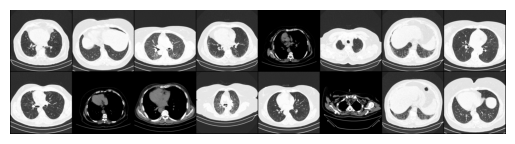

[0. 0. 1. 1. 0. 1. 0. 0.]


In [5]:
# Extract one batch

example_batchv = next(iter(vis_dataval))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same class of image, label is 0, same classe of image in both
concatenated = torch.cat((example_batchv[0], example_batchv[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batchv[2].numpy().reshape(-1))

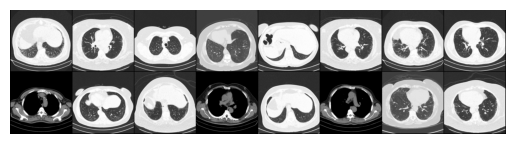

[0. 1. 1. 0. 1. 0. 0. 1.]


In [6]:
# Extract one batch
example_batcht = next(iter(vis_datatrain))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batcht[0], example_batcht[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batcht[2].numpy().reshape(-1))

In [7]:
from utils.siamese_network import SiameseNetwork, ContrastiveLoss

In [8]:
tmp=SiameseNetwork()
print(tmp.Vgg11)

d:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

<img src="images\loss_fnc.png" width="500" align="center"/>

In [9]:
# Load the training dataset
train_dataloader = DataLoader(siamese_datatrain,
                        shuffle=True,
                        num_workers=0, #8
                        batch_size=64)
# Load the validation dataset
val_dataloader = DataLoader(siamese_dataval,
                        shuffle=True,
                        num_workers=0, #8
                        batch_size=64)

dataloaders={'train': train_dataloader,
              'val': val_dataloader}

In [10]:
#net = SiameseNetwork().cuda()
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

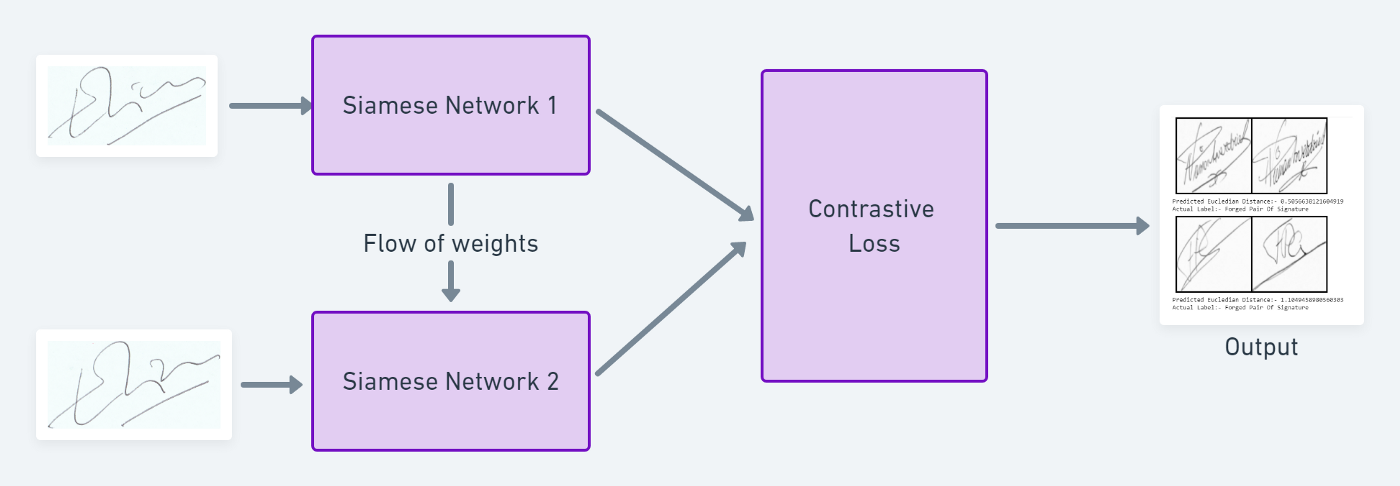

In [11]:
model,metrics =net.train_eval(net,optimizer,criterion,dataloaders,num_epochs = 100)

Epoch 1/100
----------
img0 torch.Size([64, 3, 224, 224])
label tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
preds1Array [0 0 0 0 0]
labelP [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


d:\Develop\proyecto_covid_omar\utils\siamese_network.py:111: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  preds3ArrayT = torch.Tensor(list(preds3Array))


Loss: 1.0929 Acc: 0.5469 
Epoch number 0/100 Current loss 1.0928605794906616/100
img0 torch.Size([64, 3, 224, 224])
label tensor([[1.],
        [1.],
        [0.],
        [0.],
        [1.]], device='cuda:0')
preds1Array [0 0 0 0 0]
labelP [[1.]
 [1.]
 [0.]
 [0.]
 [1.]]
img0 torch.Size([64, 3, 224, 224])
label tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
preds1Array [3 0 3 3 2]
labelP [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
img0 torch.Size([64, 3, 224, 224])
label tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.]], device='cuda:0')
preds1Array [3 0 0 3 2]
labelP [[1.]
 [1.]
 [0.]
 [1.]
 [0.]]
img0 torch.Size([64, 3, 224, 224])
label tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')
preds1Array [0 0 2 0 0]
labelP [[1.]
 [0.]
 [1.]
 [0.]
 [1.]]
img0 torch.Size([64, 3, 224, 224])
label tensor([[0.],
        [0.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
preds1Array [1 0 0 2 0]
la

KeyboardInterrupt: 

In [ ]:
# show_plot(counter, loss_history)
# show_plot(counter, acc)
# show_plot(counter, loss)
# print('counter =',counter)
# print('loss_history =',loss_history)
# print('loss =',loss)


In [ ]:
#counter = [10, 20, 30, 40]
#loss_history = [1.3514400720596313, 1.1609586477279663, 1.2165608406066895, 1.7493290901184082]
#loss = [1.3514400720596313, 1.1891521215438843, 1.19082022231156, 1.7493290901184082]
#show_plot(counter, loss_history)
#show_plot(counter, loss)
print('acc = ',acc)
print('loss = ',loss)
print('counter = ',counter)


In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="G:/Meu Drive/Colab Notebooks/DNN/Post_covit/dataset_jpg1/test")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0, x1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

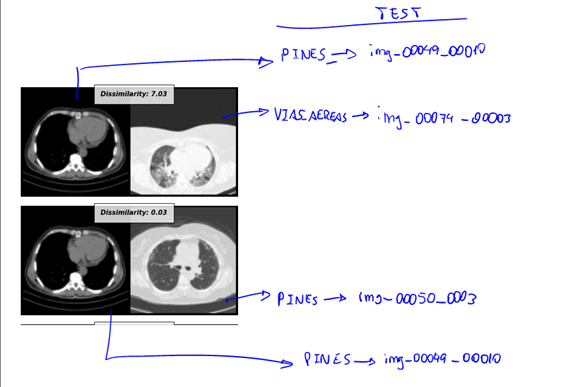

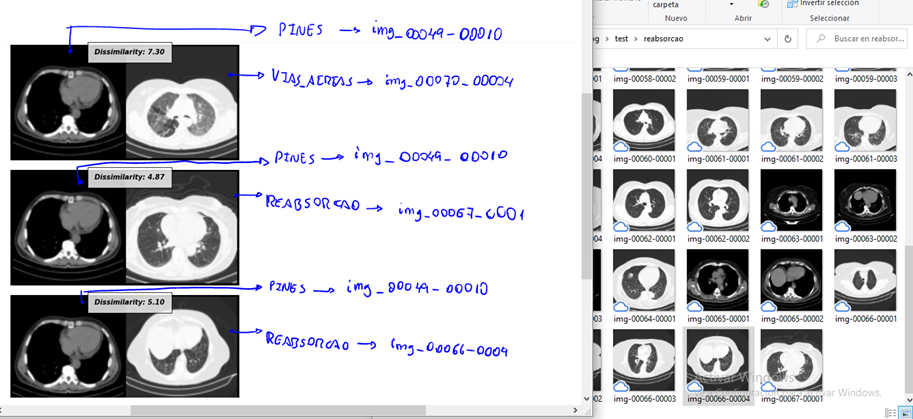

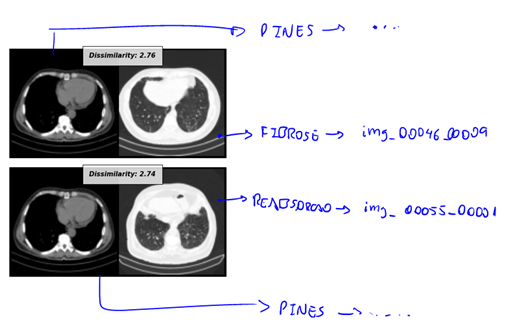